# Analysis of Amazon Food review dataset with the help of t-SNE 


In [1]:
#loading all the required modules
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
import re
from gensim.models import word2vec
import pickle
from gensim.models import KeyedVectors
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn import decomposition
pca = decomposition.PCA()
from sklearn.manifold import TSNE
from scipy.sparse import csc_matrix
from tqdm import tqdm

In [66]:
#loading the data through sqlite and preprocesing it a little bit.
temp = sqlite3.connect('/home/blurryface/Documents/database.sqlite')
temp = pd.read_sql_query("""SELECT * FROM Reviews WHERE SCORE != 3""", temp)
def partiton(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative'
score = temp['Score']
positive_negative = score.map(partiton)
temp['Score'] = positive_negative


In [3]:
#sorting the ProductId's
sorted_values = temp.sort_values('ProductId', axis = 0, ascending = True, inplace = False, kind = 'quicksort')

In [4]:
#getting rid of the duplicates
final = sorted_values.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [6]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
def clean_html(sentence):
    clean = re.compile('<.*?>')
    cleantext = re.sub(clean, ' ', sentence)
    return cleantext
def clean_punctuation(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned


In [7]:
i=0
strl = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s = ''
for sent in final['Text'].values:
    sent = clean_html(sent)
    filtered_sentence = []
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

In [8]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [9]:
final.head(3)
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [10]:
clean_data = open("clean_data.pickle", "wb")
pickle.dump(final, clean_data)
clean_data.close()

In [2]:
pickle_in = open("clean_data.pickle", "rb")
final = pickle.load(pickle_in)

# (1) BOW

In [11]:
count_vect = CountVectorizer()
final_vect = count_vect.fit_transform(final['CleanedText'].values)

In [14]:
final_vect.shape

(364171, 71624)

In [15]:
len(count_vect.get_feature_names())

71624

In [16]:
coo = final_vect.tocoo(copy=False)

In [24]:
final_array = final_vect[0: 1000].toarray()

In [25]:
type(final_array)

numpy.ndarray

In [26]:
final_df = pd.DataFrame(final_array)

In [27]:
final_df.shape

(1000, 71624)

In [29]:
standardized_data = StandardScaler().fit_transform(final_df)
type(standardized_data)

numpy.ndarray

# t-SNE visualization for BOW

### with perplexity = 10, iterations = 500

In [35]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=500)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(1000))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
#sns.FacetGrid(tsne_df, hue_"Score", size=6).map(plt.scatter, "Dim_1", "Dim_2").add_legend()
#plt.show()

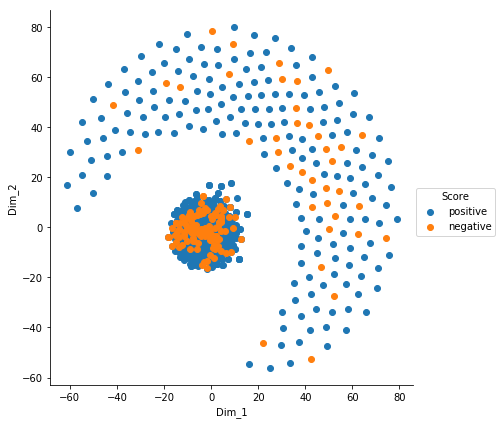

In [36]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### with perplexity = 30 and iterations = 500

In [37]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=500)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(1000))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

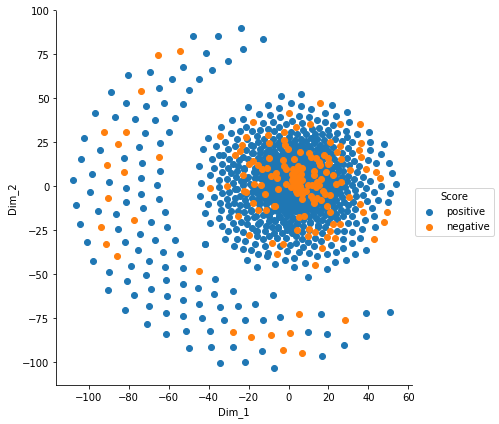

In [38]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### with perplexity = 25 and iterations = 1000

In [39]:
model = TSNE(n_components=2, random_state=0, perplexity=25, n_iter=1000)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(1000))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

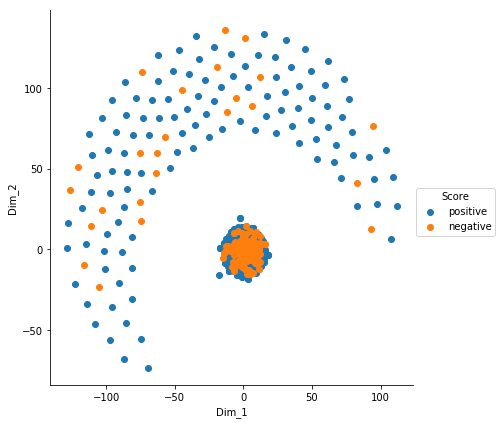

In [40]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### with perplexity = 25 and iterations = 2000

In [41]:
model = TSNE(n_components=2, random_state=0, perplexity=25, n_iter=2000)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(1000))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

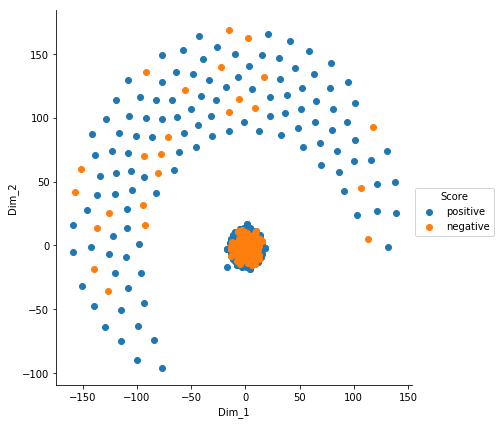

In [42]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# (2) TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 71624)
the number of unique words including both unigrams and bigrams  71624


In [4]:
final_tf_idf.shape

(364171, 71624)

In [7]:
tf_idf_final = final_tf_idf[0: 1000].toarray()
len(tf_idf_final)

1000

In [8]:
tf_idf_data = pd.DataFrame(tf_idf_final)
tf_idf_data.shape

(1000, 71624)

# t-SNE visulization of TF-IDF

### with perplexity = 10, iterations = 500

In [10]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=500)
tsne_data = model.fit_transform(tf_idf_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(1000))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

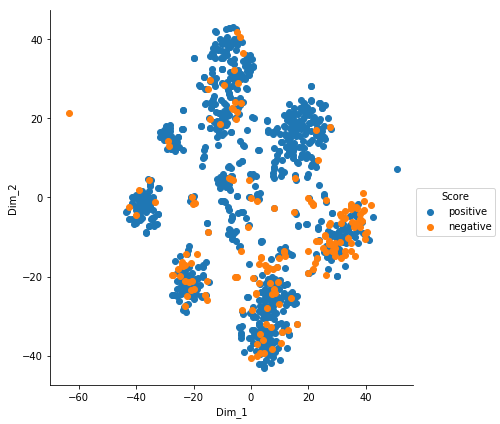

In [11]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### with perplexity = 20, iterations = 500

In [12]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=500)
tsne_data = model.fit_transform(tf_idf_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(1000))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

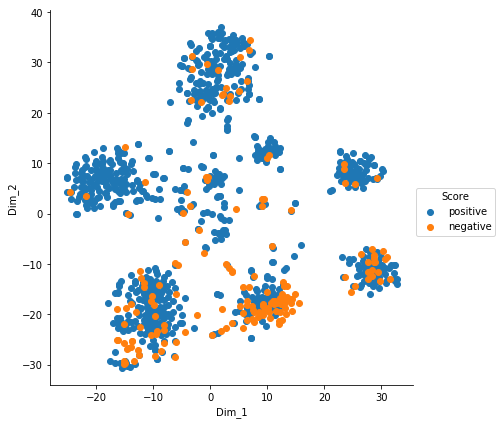

In [13]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### with perplexity = 20, iterations = 1000

In [14]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=1000)
tsne_data = model.fit_transform(tf_idf_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(1000))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

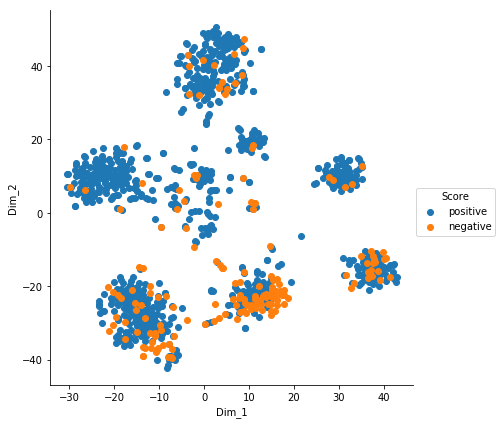

In [15]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

###  with perplexity 30 and iterations = 2000

In [16]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=2000)
tsne_data = model.fit_transform(tf_idf_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(1000))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

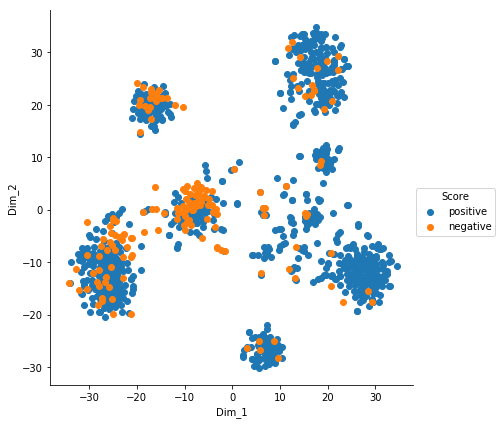

In [17]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# W2V

In [3]:
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [4]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [21]:
w2v_words = list(w2v_model.wv.vocab)

# Average Word2Vector

In [9]:
sent_vectors = []
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    cnt_words =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

364171
50


In [11]:
sent_vector_df = pd.DataFrame(sent_vectors)

In [13]:
data = sent_vector_df[0: 10000]

In [15]:
standardized_data = StandardScaler().fit_transform(data)

In [16]:
standardized_data.shape

(10000, 50)

In [17]:
models = open("models.pickle", "wb")
pickle.dump(standardized_data, models)
models.close()

# t-SNE visualization of Average Word2Vec

### with perplexity 30 and iterations 1000

In [19]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(10000))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

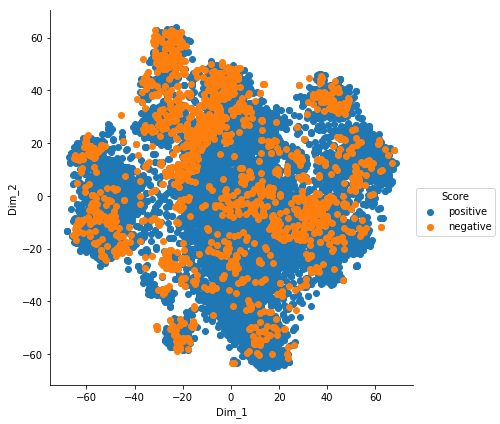

In [20]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### with perplexity 20 and iterations 1000

In [22]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=1000)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(10000))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

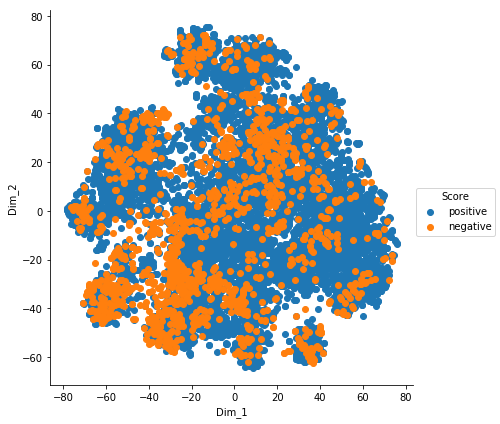

In [23]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### with perplexity 50 and iterations 2000

In [24]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=2000)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(10000))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

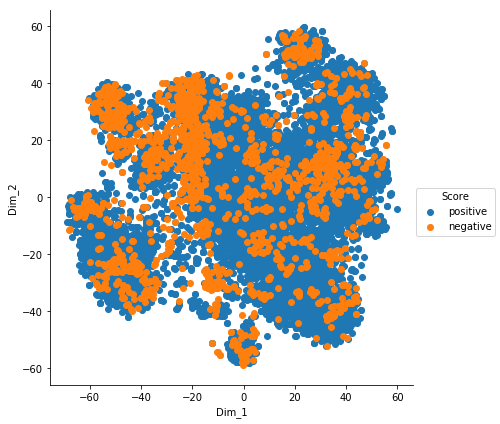

In [25]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [27]:
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=3000)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(10000))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

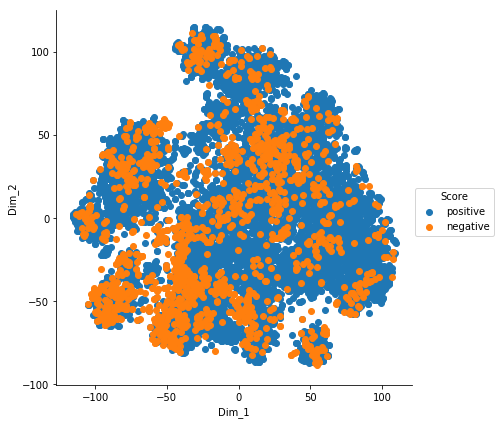

In [28]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TF-IDF Word2Vec

In [24]:
final = final[0: 1000]
final['Score'].describe()

count         1000
unique           2
top       positive
freq           831
Name: Score, dtype: object

In [33]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)


In [5]:
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [48]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=100, workers=4)

In [49]:
w2v_words = list(w2v_model.wv.vocab)

In [50]:

tfidf_feat = tf_idf_vect.get_feature_names() 


tfidf_sent_vectors = []
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(100) 
    weight_sum =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [51]:
sent_vector_df = pd.DataFrame(sent_vec)

In [52]:
standardized_data = StandardScaler().fit_transform(sent_vector_df)
standardized_data.shape

(100, 1)

In [53]:
models = open("models.pickle", "wb")
pickle.dump(standardized_data, models)
models.close()

# t-SNE visualization of TF-IDF W2V

### with perplexity 10 and iterations 1000

In [56]:
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=1000)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(100))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

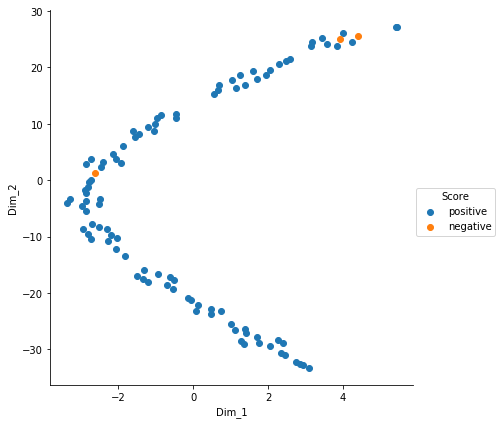

In [57]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### with perplexity 50 and iterations 1000

In [58]:
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1000)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(100))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

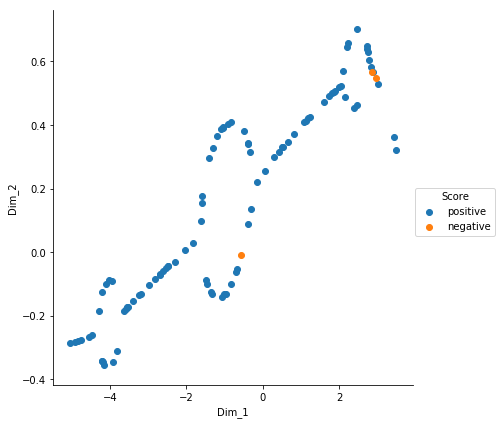

In [59]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### with perplexity 30 and iterations 10000

In [62]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=10000)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(100))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

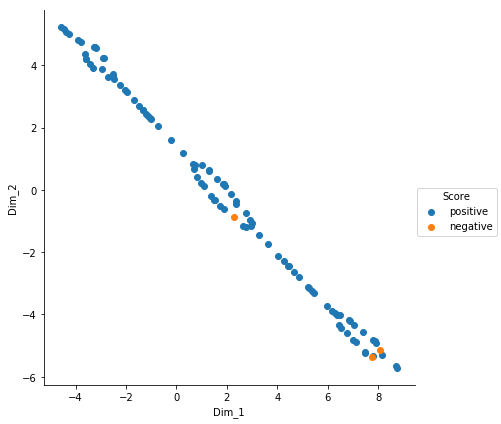

In [63]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### with perplexity 100 and iterations 10000

In [64]:
model = TSNE(n_components=2, random_state=0, perplexity=100, n_iter=10000)
tsne_data = model.fit_transform(standardized_data)
tsne_data = np.vstack((tsne_data.T, final['Score'].head(100))).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

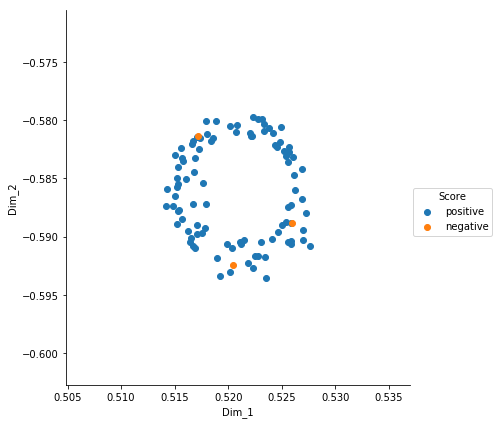

In [65]:
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Observations :- Here we did the t-SNE visualization of BOW, TF-IDF, Average W2V, TF-IDF Weighted W2V.

#### Note:- Only a small number of points were taken each time as the code was taking too long to run.